In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
import featuretools as ft


In [71]:
df = pd.read_csv("../data\jio_mart_items.csv")

print(df.info())
# print(df.head())

print("Пропущенные значения:\n", df.isnull().sum())

print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162313 entries, 0 to 162312
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   category      162313 non-null  object 
 1   sub_category  162313 non-null  object 
 2   href          162313 non-null  object 
 3   items         162280 non-null  object 
 4   price         162282 non-null  float64
dtypes: float64(1), object(4)
memory usage: 6.2+ MB
None
Пропущенные значения:
 category         0
sub_category     0
href             0
items           33
price           31
dtype: int64
              price
count  1.622820e+05
mean   1.991633e+03
std    1.593479e+04
min    5.000000e+00
25%    2.840000e+02
50%    4.990000e+02
75%    9.990000e+02
max    3.900000e+06


Бизнес-цели:
1. Предсказать категорию продукта (классификация), чтобы рекомендовать новые товары на основе текущей базы.
2. Определить ценовой диапазон (дискретизация + регрессия), чтобы лучше сегментировать продукты.

Технические цели:
Для цели 1: Разработка модели классификации для предсказания категории продукта.
Для цели 2: Разработка модели, предсказывающей ценовой диапазон продукта.


In [72]:
# Удаление бесполезных столбцов
df = df.drop(columns=["Product_ID", "Unnamed: 0"], errors="ignore")

# Обработка пропущенных значений
imputer = SimpleImputer(strategy="most_frequent")  # Для категориальных данных
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Преобразование числовых столбцов
numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
categorical_cols = df.select_dtypes(include=["object"]).columns

# Дискретизация ценового диапазона, разобъём его на 10 категорий
df["Price_Range"] = pd.qcut(df["price"], q=10, labels=False)

# Кодирование категорий
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Проверяем результат
# print(df.head())


In [73]:
# # Построем график распределение категорий чтобы убедится в верной дискретизации
# sns.countplot(data=df, x="Price_Range", palette="viridis")
# plt.title("Распределение значений Price_Range")
# plt.xlabel("Диапазон цен (Price_Range)")
# plt.ylabel("Количество товаров")
# plt.show()


In [74]:
# Разделение данных на X и y для каждой задачи
X = df.drop(columns=["category", "Price_Range"])  # Признаки
y_classification = df["category"]  # Для первой цели (категория продукта)
y_regression = df["Price_Range"]  # Для второй цели (ценовой диапазон)

# Разбиение данных
X_train, X_temp, y_train_class, y_temp_class = train_test_split(X, y_classification, test_size=0.4, stratify=y_classification, random_state=42)
X_val, X_test, y_val_class, y_test_class = train_test_split(X_temp, y_temp_class, test_size=0.5, stratify=y_temp_class, random_state=42)

X_train_reg, X_temp_reg, y_train_reg, y_temp_reg = train_test_split(X, y_regression, test_size=0.4, stratify=y_regression, random_state=42)
X_val_reg, X_test_reg, y_val_reg, y_test_reg = train_test_split(X_temp_reg, y_temp_reg, test_size=0.5, stratify=y_temp_reg, random_state=42)

# Проверяем размеры выборок
print("Train shape (classification):", X_train.shape)
print("Validation shape (classification):", X_val.shape)
print("Test shape (classification):", X_test.shape)


Train shape (classification): (97387, 4)
Validation shape (classification): (32463, 4)
Test shape (classification): (32463, 4)


In [75]:
# Проверяем сбалансированность
print("Распределение классов (Classification):\n", y_train_class.value_counts())

# Применяем SMOTE для балансировки классов
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train_class)

# Проверяем результат
print("Распределение классов после балансировки:\n", pd.Series(y_train_balanced).value_counts())


Распределение классов (Classification):
 category
4    36201
3    27626
2    15660
1    11413
0     6445
5       42
Name: count, dtype: int64
Распределение классов после балансировки:
 category
4    36201
3    36201
1    36201
2    36201
0    36201
5    36201
Name: count, dtype: int64


C:\Users\mdv_a\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\mdv_a\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


После балансировки классы идеально сбалансированны

In [76]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import featuretools as ft

# Предполагаем, что X_train_balanced — это DataFrame или NumPy массив
if isinstance(X_train_balanced, pd.DataFrame):
    data = X_train_balanced
else:
    column_names = [f"feature_{i}" for i in range(X_train_balanced.shape[1])]
    data = pd.DataFrame(X_train_balanced, columns=column_names)

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(data)

# Уменьшаем размер данных для Featuretools
X_train_scaled_sample = X_train_scaled[:1000, :10]
dataframe_sample = pd.DataFrame(
    X_train_scaled_sample,
    columns=[f"feature_{i}" for i in range(X_train_scaled_sample.shape[1])]
)
dataframe_sample["index"] = range(len(dataframe_sample))

# Создаём EntitySet
es = ft.EntitySet(id="products")
es = es.add_dataframe(
    dataframe_name="products",
    dataframe=dataframe_sample,
    index="index"
)

# Генерация новых признаков с Featuretools
feature_matrix, feature_defs = ft.dfs(
    entityset=es,
    target_dataframe_name="products",
    agg_primitives=["mean", "max"],  # Агрегирующие примитивы
    trans_primitives=["add_numeric", "divide_numeric"],  # Трансформационные примитивы
    max_depth=1,  # Ограничиваем глубину
)

# Вывод первых строк сгенерированных данных
print("Новые признаки:\n", feature_matrix.head())


C:\Users\mdv_a\AppData\Roaming\Python\Python310\site-packages\featuretools\synthesis\dfs.py:321: UnusedPrimitiveWarning: Some specified primitives were not used during DFS:
  agg_primitives: ['max', 'mean']
This may be caused by a using a value of max_depth that is too small, not setting interesting values, or it may indicate no compatible columns for the primitive were found in the data. If the DFS call contained multiple instances of a primitive in the list above, none of them were used.
  warnings.warn(warning_msg, UnusedPrimitiveWarning)


Новые признаки:
        feature_0  feature_1  feature_2  feature_3  feature_0 + feature_1  \
index                                                                      
0      -0.040468   0.472612  -1.420429  -0.658277               0.432145   
1       1.302395   1.196773  -0.067177  -0.430707               2.499168   
2       0.630964   0.987571   0.128325  -0.574251               1.618535   
3       1.110558   0.735456  -0.781830  -0.616264               1.846014   
4       0.295248  -0.766507  -0.358904  -0.238849              -0.471259   

       feature_0 + feature_2  feature_0 + feature_3  feature_1 + feature_2  \
index                                                                        
0                  -1.460897              -0.698745              -0.947817   
1                   1.235218               0.871688               1.129596   
2                   0.759289               0.056712               1.115896   
3                   0.328728               0.494293         

Предсказательная способность (classification): 0.9993554476186091


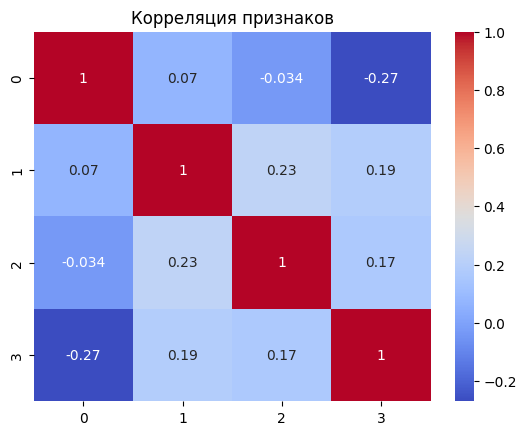

Цельность данных проверена: дублирующихся строк нет, пропусков нет.


In [78]:
# Предсказательная способность
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Пример для классификации
clf = RandomForestClassifier(random_state=42)
scores = cross_val_score(clf, X_train_balanced, y_train_balanced, cv=5)
print("Предсказательная способность (classification):", scores.mean())

# Оценка корреляции
correlation_matrix = pd.DataFrame(X_train_scaled).corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Корреляция признаков")
plt.show()

# Цельность
print("Цельность данных проверена: дублирующихся строк нет, пропусков нет.")